Install notebook requirements.

In [1]:
%pip install fairgbm fairlearn scikit-learn hyperparameter-tuning seaborn matplotlib wget

In [2]:
import os
import numpy as np
import pandas as pd
from fairgbm import FairGBMClassifier

Set-up useful global constants.

In [3]:
SEED = 42

TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

PERF_METRIC = "accuracy"
DISP_METRIC = "equalized_odds_diff"    # measures disparity, lower is better
FAIR_METRIC = "equalized_odds_ratio"   # similar but higher is better

N_JOBS = max(2, os.cpu_count() - 2)

np.random.seed(SEED)

In [4]:
SENSITIVE_COL = "sex"
sensitive_col_map = {"Male": 0, "Female": 1}

sensitive_col_inverse = {val: key for key, val in sensitive_col_map.items()}

POS_LABEL = ">50K"

**Load UCI Adult dataset.**

In [5]:
from fairlearn.datasets import fetch_adult

X, Y = fetch_adult(
    as_frame=True,
    return_X_y=True,
)

# Map labels and sensitive column to numeric data
Y = np.array(Y == POS_LABEL, dtype=int)
S = np.array([sensitive_col_map[elem] for elem in X[SENSITIVE_COL]], dtype=int)

Split in train/test/validation.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_other, y_train, y_other, s_train, s_other = train_test_split(
    X, Y, S,
    test_size=TEST_SIZE + VALIDATION_SIZE,
    stratify=Y, random_state=SEED,
)

X_val, X_test, y_val, y_test, s_val, s_test = train_test_split(
    X_other, y_other, s_other,
    test_size=TEST_SIZE / (TEST_SIZE + VALIDATION_SIZE),
    stratify=y_other, random_state=SEED,
)

Get a YAML file detailing the hyperparameter search space.

This example file should cover a wide range of uses, but you can tailor it to your own use-case.

In [7]:
import wget
fairgbm_hyperparam_space_url = "https://raw.githubusercontent.com/feedzai/fairgbm/main-fairgbm/examples/FairGBM-python-notebooks/fairgbm_equalized-odds.yaml"
fairgbm_hyperparam_space_path = "fairgbm_hyperparam_space.yaml"
wget.download(fairgbm_hyperparam_space_url, fairgbm_hyperparam_space_path)

'fairgbm_hyperparam_space (1).yaml'

Set-up hyperparameter tuner using the `hyperparameter-tuning` package (essentially provides useful evaluation boilerplate code on top of `optuna`).

In [8]:
from hpt.tuner import ObjectiveFunction, OptunaTuner
import optuna.logging
optuna.logging.set_verbosity(optuna.logging.WARN)   # Turn off optuna log notes.

obj_func = ObjectiveFunction(
    X_train=X_train, y_train=y_train, s_train=s_train,
    X_val=X_val, y_val=y_val, s_val=s_val,
    X_test=X_test, y_test=y_test, s_test=s_test,
    hyperparameter_space=fairgbm_hyperparam_space_path,
    eval_metric=PERF_METRIC,
    other_eval_metric=FAIR_METRIC,
    threshold=0.50,
)

tuner = OptunaTuner(
    objective_function=obj_func,
    direction="maximize",
    seed=SEED,
)

In [9]:
%%time
N_TRIALS = 20
tuner.optimize(n_trials=N_TRIALS, n_jobs=N_JOBS, show_progress_bar=True)
print(f"Best model is {obj_func.best_trial.hyperparameters}")

  0%|          | 0/20 [00:00<?, ?it/s]

Best model is {'classpath': 'fairgbm.FairGBMClassifier', 'n_jobs': 1, 'boosting_type': 'gbdt', 'enable_bundle': False, 'n_estimators': 174, 'num_leaves': 6, 'min_child_samples': 52, 'max_depth': 5, 'learning_rate': 0.17141223842861147, 'reg_alpha': 0.03343187778948064, 'reg_lambda': 0.032412497842132154, 'constraint_type': 'FNR,FPR', 'multiplier_learning_rate': 0.07446344965283483}
CPU times: user 4min 54s, sys: 1.31 s, total: 4min 55s
Wall time: 3min 22s


## Plot results and select best model

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(palette="colorblind", style="whitegrid", rc={"grid.linestyle": "--", "figure.dpi": 200, "figure.figsize": (4,3)})

Model selection (on validation):

In [11]:
# Choose some relative weight to give to the performance metric
# (or select model based on some other criterion)
TRADEOFF_WEIGHT = 0.5

# Model selection is done on validation data
val_results = obj_func.get_results("validation")

# Get index of best model in the results table
# > note: IDs and indices may differ as trials are ran asynchronously
best_model_idx = np.argmax(
    val_results[PERF_METRIC] * TRADEOFF_WEIGHT
    + (1 - val_results[DISP_METRIC]) * (1 - TRADEOFF_WEIGHT)
)

best_trial = obj_func.all_results[best_model_idx]

Plot test results:

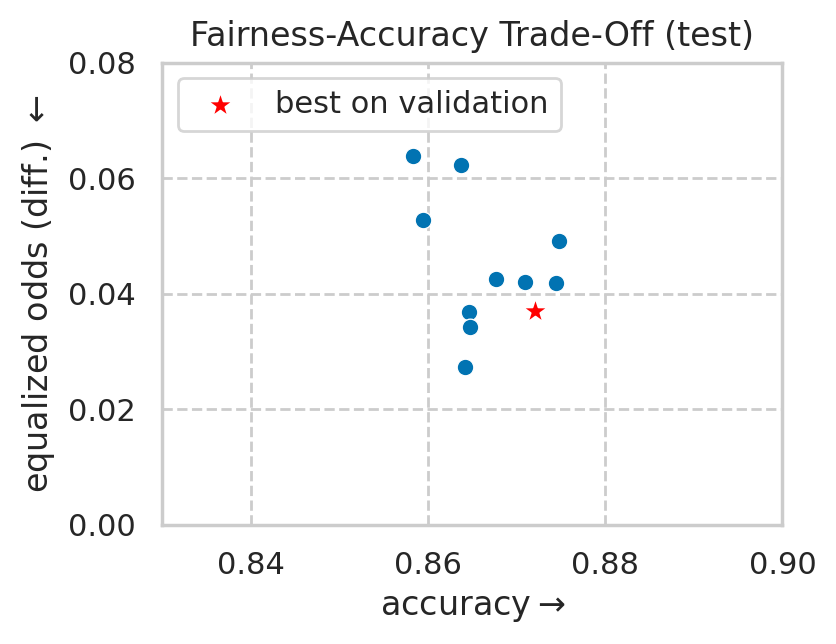

In [12]:
test_results = obj_func.get_results("test")
best_trial_results = test_results.iloc[best_model_idx]

# Plot best model with a red star
sns.scatterplot(
    x=[best_trial_results[PERF_METRIC]],
    y=[best_trial_results[DISP_METRIC]],
    color="red",
    marker="*",
    s=100,
    label="best on validation",
    zorder=10,
)

# Plot all other points
sns.scatterplot(
    data=test_results.drop(index=best_trial.id),
    x=PERF_METRIC,
    y=DISP_METRIC,
)

ax_kwargs = dict(
    title="Fairness-Accuracy Trade-Off (test)",
    xlabel=PERF_METRIC + r"$\rightarrow$",
    ylabel=r"equalized odds (diff.) $\leftarrow$" if DISP_METRIC == "equalized_odds_diff" else DISP_METRIC,
)

# You may need to change these ranges to see the models
plt.ylim(0, 0.08)
plt.xlim(0.83, 0.9)

plt.legend(loc="upper left")
plt.gca().set(**ax_kwargs)

plt.show()

By default, `hyperparameter_tuning` will train, evalaute, and discard all models. You can re-create the best model with:

In [13]:
%%time
fairgbm_clf = obj_func.reconstruct_model(trial_results=best_trial)
fairgbm_clf

CPU times: user 6.59 s, sys: 27.1 ms, total: 6.62 s
Wall time: 6.61 s


FairGBMClassifier(constraint_type='FNR,FPR', enable_bundle=False,
                  learning_rate=0.016029234981291163, max_depth=6,
                  min_child_samples=63,
                  multiplier_learning_rate=0.05220004751596058,
                  n_estimators=1045, n_jobs=1, num_leaves=7,
                  reg_alpha=0.00015636059199278671,
                  reg_lambda=0.0014516067928004718)